In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [2]:
df= pd.read_csv('uci-secom.csv')
df.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [3]:
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [4]:
df_na=null_values(df)
df_na

,Missing_Records,Percentage (%)
292,1429,91.193363
293,1429,91.193363
157,1429,91.193363
158,1429,91.193363
358,1341,85.577537
...,...,...
456,1,0.063816
218,1,0.063816
356,1,0.063816
457,1,0.063816


In [5]:
df_na=df_na[df_na['Percentage (%)']>50]
df_na

,Missing_Records,Percentage (%)
292,1429,91.193363
293,1429,91.193363
157,1429,91.193363
158,1429,91.193363
358,1341,85.577537
85,1341,85.577537
492,1341,85.577537
220,1341,85.577537
518,1018,64.964901
246,1018,64.964901


It can be said that 91.18% of the features have missing records,so here we shall ascertain the features which have more than 50% missing values because even imputation wont help if more than 50% of data is missing

In [6]:
# These 28 features must be dropped
df_na.shape

(28, 2)

In [7]:
df=df.drop(axis=1,columns=df_na.index)
df.shape

(1567, 564)

Now for the features with missing records less than 50% we shall use KNN imputer for filling missing values

In [8]:
## see the sklearn documentation for KNN imputer
from sklearn.impute import KNNImputer
imputer= KNNImputer(n_neighbors=3,weights='distance')

In [9]:
# Seperte independent and dependent features
X=df.drop('Pass/Fail',axis=1)
y=df['Pass/Fail']

In [10]:
X.drop('Time',axis=1,inplace=True)

In [11]:
imputer.fit(X)
X_clean=imputer.transform(X)

In [12]:
X=pd.DataFrame(X_clean)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,552,553,554,555,556,557,558,559,560,561
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,1.6765,14.9509,0.5005,0.0118,0.0035,2.3630,0.016581,0.01377,0.004687,78.368624
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,1.1065,10.9003,0.5019,0.0223,0.0055,4.4447,0.009600,0.02010,0.006000,208.204500
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,2.0952,9.2721,0.4958,0.0157,0.0039,3.1745,0.058400,0.04840,0.014800,82.860200
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,1.7585,8.5831,0.4990,0.0103,0.0025,2.0544,0.020200,0.01490,0.004400,73.843200
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,1.6597,10.9698,0.4800,0.4766,0.1045,99.3032,0.020200,0.01490,0.004400,73.843200


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Pass or Fail')

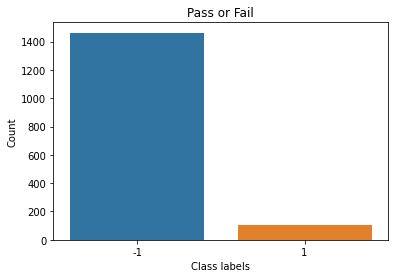

In [14]:
sns.countplot(df['Pass/Fail'])
plt.xlabel('Class labels')
plt.ylabel('Count')
plt.title('Pass or Fail')

The Class imbalance is too high in favour of Passing(encoded as-1), therefore any model would give us a biased response towards -1 

In [15]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,stratify=y,random_state=5)

In [78]:
y_test.value_counts()

-1    302
 1    159
Name: Pass/Fail, dtype: int64

In [17]:
X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train),index=X_train.index)
X_test_scaled=pd.DataFrame(scaler.fit_transform(X_test))

### Over Sampling

#### 1) SMOTE

In [18]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

In [19]:
# the strategy implies that the minority class wil half the number of labels the majority class has
oversample= SMOTE(sampling_strategy=0.5)

In [20]:
print ('Original dataset distribution: {}'.format(Counter(y_train)))
X_res,y_res=oversample.fit_resample(X_train_scaled,y_train)
print ('Resampled dataset distribution: {}'.format(Counter(y_res)))

Original dataset distribution: Counter({-1: 1023, 1: 73})
Resampled dataset distribution: Counter({-1: 1023, 1: 511})


#### 2) RandomOverSampler

In [21]:
from imblearn.over_sampling import RandomOverSampler 
rand_oversamp= RandomOverSampler(sampling_strategy='auto')

In [22]:
print ('Original dataset distribution: {}'.format(Counter(y_train)))
X_res1,y_res1=rand_oversamp.fit_resample(X_train_scaled,y_train)
print ('Resampled dataset distribution: {}'.format(Counter(y_res1)))

Original dataset distribution: Counter({-1: 1023, 1: 73})
Resampled dataset distribution: Counter({-1: 1023, 1: 1023})


What I observed is that both these techniques are yielding the same indistinguishable outcomes, nevertheless if we choose a sample proportion similar to 10:10 then we might get a model that might not generalize well on the test set , hence the ratio of 10:5 is preferrable

### Model building

First round we will create preliminary classifier models then based on those results we can determine if hyper parameter optimization is warranted or not

### 1) Logistic regression

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
lr= LogisticRegression()
lr.fit(X_res,y_res)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [25]:
y_pred = lr.predict(X_test_scaled)

In [26]:
print('The models accuracy score is', accuracy_score(y_pred,y_test))

The models accuracy score is 0.8428874734607219


In [27]:
print(confusion_matrix(y_pred,y_test))
print(classification_report(y_pred,y_test))

[[392  26]
 [ 48   5]]
              precision    recall  f1-score   support

          -1       0.89      0.94      0.91       418
           1       0.16      0.09      0.12        53

    accuracy                           0.84       471
   macro avg       0.53      0.52      0.52       471
weighted avg       0.81      0.84      0.82       471



### 2) XG Boost 

In [28]:
xgb= XGBClassifier()
xgb.fit(X_res,y_res)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [29]:
y_pred1= xgb.predict(X_test_scaled)

In [30]:
print('The models accuracy is',accuracy_score(y_pred1,y_test))

The models accuracy is 0.9150743099787686


In [31]:
print(confusion_matrix(y_pred1,y_test))
print(classification_report(y_pred1,y_test))

[[429  29]
 [ 11   2]]
              precision    recall  f1-score   support

          -1       0.97      0.94      0.96       458
           1       0.06      0.15      0.09        13

    accuracy                           0.92       471
   macro avg       0.52      0.55      0.52       471
weighted avg       0.95      0.92      0.93       471



### 3) Support Vector Machines

In [32]:
svc= SVC()
svc.fit(X_res,y_res)

SVC()

In [33]:
y_pred2= svc.predict(X_test_scaled)

In [34]:
print('The models accuracy is', accuracy_score(y_pred2,y_test))

The models accuracy is 0.9256900212314225


In [35]:
print(confusion_matrix(y_pred2,y_test))
print(classification_report(y_pred2,y_test))

[[436  31]
 [  4   0]]
              precision    recall  f1-score   support

          -1       0.99      0.93      0.96       467
           1       0.00      0.00      0.00         4

    accuracy                           0.93       471
   macro avg       0.50      0.47      0.48       471
weighted avg       0.98      0.93      0.95       471



This is quite suspicious that no data point is classified under rejected class, therfore we shall see if the model is biased towards the majority class

In [37]:
svc.fit(X_res,y_res)
tr_pred= svc.predict(X_res)
print(accuracy_score(tr_pred,y_res))

0.9986962190352021


In [38]:
print(confusion_matrix(tr_pred,y_res))

[[1023    2]
 [   0  509]]


Its clear that model is performing excellent on training, still nevertheless performance on the test is slighly lower than the one on train set

### 4) RandomForest Classifier

In [39]:
rf= RandomForestClassifier()
rf.fit(X_res,y_res)

RandomForestClassifier()

In [40]:
y_pred3= rf.predict(X_test_scaled)

In [41]:
print('The models accuracy is', accuracy_score(y_pred3,y_test))

The models accuracy is 0.9341825902335457


In [43]:
print(confusion_matrix(y_pred3,y_test))
print(classification_report(y_pred3,y_test))

[[440  31]
 [  0   0]]
              precision    recall  f1-score   support

          -1       1.00      0.93      0.97       471
           1       0.00      0.00      0.00         0

    accuracy                           0.93       471
   macro avg       0.50      0.47      0.48       471
weighted avg       1.00      0.93      0.97       471



/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The inherent problem of the dataset is that the class imbalance is unquestionably hig, hence as an inevitable outcome one particular class has the highest number of datapoints classified under it

As a secondary objective of the problem statement dimensionality reduction must be performed and then assess if we get any further improvement in the models predictive accuracy

### Dimensionality Reduction with PCA

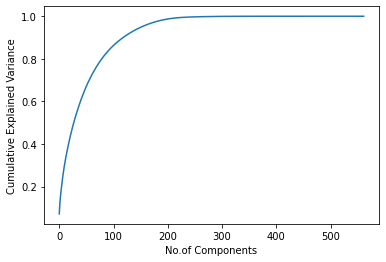

In [66]:
from sklearn.decomposition import PCA

pca= PCA().fit(X_res)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('No.of Components')
plt.ylabel('Cumulative Explained Variance');

In [67]:
# We can choose 'arpack' because we have verified the condition 0 < n_components < min(X.shape)
# because we have 0 < 200 < 563
pca=PCA(n_components=200,svd_solver='arpack')
pca.fit(X_res)

PCA(n_components=200, svd_solver='arpack')

In [68]:
pca_dat= pca.transform(X_res)
pca_dat.shape

(1534, 200)

In [69]:
X_train,X_test,y_train,y_test=train_test_split(pca_dat,y_res,test_size=0.3)

In [71]:
Classifiers=[
    LogisticRegression(),
    SVC(),
    RandomForestClassifier(),
    XGBClassifier()
]

In [72]:
import time

In [73]:
def accuracy(X_train,X_test,y_train,y_test):
    for clf in Classifiers:
        s=time.time()
        clf.fit(X_train,y_train)
        y_pred= clf.predict(X_test)
        acc=accuracy_score(y_pred,y_test)
        e=time.time()
        print(f"Accuracy: {round(acc,3)} \t Time(in secs): {round(e-s,3)} \t Classifier: {clf.__class__.__name__}")

In [74]:
accuracy(X_train,X_test,y_train,y_test)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.898 	 Time(in secs): 0.248 	 Classifier: LogisticRegression
Accuracy: 0.98 	 Time(in secs): 0.3 	 Classifier: SVC
Accuracy: 0.963 	 Time(in secs): 1.144 	 Classifier: RandomForestClassifier
Accuracy: 0.989 	 Time(in secs): 5.247 	 Classifier: XGBClassifier


Of all the models XG Boost classifier was the best performer in terms of accuracy score,but however it was inefficient with contrast to SVC as it consumed about more than 5 minutes. SVC performed optimally as  therefore we will choose this model 